# *GMOdetector notebook*: Template to analyze a new batch of images
**Notebook template for applying routine hyperspectral/segmentation cross-analysis phenomics workflow over new datasets**

v.0.3.0 is updated to use new segmentation model and work without producing test alignment for every single image (to run more quickly)

<img src="Figures/WorkflowFlowchart.png">

In this workflow, images taken with the macroPhor Array dual RGB/hyperspectral imaging platform are analyzed by a workflow in which regression quantifies fluorescent signals in hyperspectral images, deep learning segments RGB images into different tissues, and these datasets are cross-referenced to produce statistics on growth of transgenic callus and shoot.

## Instructions for use
1.  Enter information for the experiment below
2. Set <font color=blue>variables</font> for data paths and parameters, as instructed by colored boxes.
3. "Save as" with filename describing experiment and anything special about this analysis (e.g. T18_OD_TAO_wk7_automation_test_attempt2.ipynb)
4. Run notebook from console, by either one of two methods:
- In the top bar of JupyterLab, select "Run" and "Run all cells"
- In a terminal, enter the below command with the notebook filename inserted<br>
```jupyter nbconvert --to HTML --ExecutePreprocessor.timeout=-1 --allow-errors --execute insert_filename_here```
5. Wait for email

## Experiment ID and quick description:

<div class="alert alert-block alert-success">
Provide a short description of the experiment in the below box. This should include unique identifier codes for the experiment, along with a short description of genotypes and treatments studied. The timepoint should also be included. </div>

## Parameters for analysis:

<div class="alert alert-block alert-success">
The below variables must be modified appropriately every time this workflow is run over new images.
</div>

### Data location
The `data` variable below provides the **complete** path to the folder containing data to be analyzed. This should include all folders and subfolders in which the data of interest is organized by. For the organizational system used for our lab's data, this should follow the format "/Experiment/Subexperiment/Timepoint/"

In [1]:
data_prefix="/media/michael/Expansio_15/"

In [2]:
data_suffix="/Fuggle_vacuum_infiltration_and_sonication/wk4/"

In [3]:
data="${data_prefix}${data_suffix}"

### Sample information
Every experiment has a randomization datasheet, which was used to organize treatment and genotype information for each plate, prepare labels, and randomize plates. The path to this file is provided through the `randomization_datasheets` variable below. This workflow requires this datasheet in order to know which plates have which genotype/treatment. At a later date, we will integrate an ability to read this data directly from labels.

In [4]:
randomization_datasheet="${data_prefix}/Fuggle_vacuum_infiltration_and_sonication/Test_4-8-22_Fuggle_vac_and_sonic_transformation.xlsx"

### Detection of missing or contaminated explants

Set the `missing_explants` variable to `"Automatic"` if using model to automatically detect missing and contaminated explants. Note that this model is only supported for plates with 12 explants. Otherwise, provide an appropriately formatted `.csv` spreadsheet (see example)  of manually scored contamination / missing explant data.

In [5]:
missing_explants="Automatic"

Enter your email where results will be sent

### Email

In [6]:
email=chris.willig@oregonstate.edu
















<div class="alert alert-block alert-warning">
All variables below should be modified only as needed to indicate the fluorescent proteins in samples and the grid layout of explants. </div>

### Fluorescent protein settings

Below should be all known fluorescent components contained in the sample. This includes each fluorescent protein, as well as a "noise" or "diffraction" term if applicable. All of these components must exist in the user's spectral library. `GMOdetector` currently comes with a spectral library that includes, by default:
- DsRed
- ZsYellow
- GFP
- Chl
- ChlA
- ChlB
- Diffraction

In [7]:
fluorophores=(DsRed Chl Diffraction) # An explanation of array variables in bash is here: https://tldp.org/LDP/Bash-Beginners-Guide/html/sect_10_02.html

The user has the option of limiting loading of hyperspectral data and subsequent regression to a specific range of wavelengths, using the `desired_wavelength_range` array variable. This range should cover all fluorophores provided in the `fluorophores` array variable able. Aside from runtime, there is no disadvantage to including a wider range than is needed.

In [8]:
desired_wavelength_range=(500 900)

### False color plot settings

To assist user inspection of regression results, false color plots can be produced by `GMOdetector` to show results of regression over whole samples. 
Note: In v0.2.0.x of the workflow, these parameters are independent of those used later by `GMOlabeler` to produce by-explant plots including false color plots. These will be made the same in a later update.
The `FalseColor_channels` array variable indicates the components to be plotted as red, green and blue, in that order.

In [9]:
FalseColor_channels=(Chl DsRed Diffraction)

The `FalseColor_caps` array variable indicates an upper limit of signal for each of these component. Any signal at or above these values will appear with maximum brightness; thus, these variables are comparable to exposure on a camera. If caps are too high, not much signal at lower ranges will be seen. If cap for a given component is too low, the false color images will appear overexposed with respect to the component.

In [10]:
FalseColor_caps=(200 400 200)

`GMOlabeler` will use the below parameters to classify individual explants on plates as positive for a given fluorescent protein or not. A single fluorescent protein is chosen for the by-explant false color plots. Multiple can be used to generate the final plots summarizing results.

In [11]:
reporters=(DsRed)

Parameters for reporter signal threshold and pixel threshold must be provided by the user. Our grid search yielded several noted below. These were most recently calculated from statistics produced with Python `GMOdetector`.

<img src="Figures/GMOlabeler_parameters.png">

In [12]:
reporter_threshold=38
pixel_threshold=3

### Grid settings

Currently, `GMOlabeler` distinguishes explants by their expected position on a plate. This is supported for plates with 12 or 20 explants, arranged in specific positions on a grid. False positives may result in cases in which one explant grows to such an extent that it intrudes into the grid square meant for an adjacent explant. <br>In the future, an additional neural network will be used to segment individual explants on a per-pixel basis, avoiding the need for crude cropping, and the outputs from the resulting model will be integrated with `GMOlabeler`.

Cropping to grid squares is supported for standard grids with 12 or 20 explants, as indicated by the `grid` variable. An image of each grid square (with a file path provided by the `grid_file` variable) will be superimposed over each image during `GMOlabeler` analysis to allow the user to easily inspect and verify grid positions.

In [13]:
grid=12

Define grid borders for the grid with an image size of 2000x2000, not yet aligned to hyperspectral images. These borders will be used for the contamination model.

In [14]:
pre_aligned_resized_grid_borders=("256,490,1720,1602")

Define grid borders for the grid after alignment. If unsure what to use, you may wish to wait until after alignment and inspection of results to set this parameter.

In [15]:
aligned_grid_borders="122 1276 1273 326"

<div class="alert alert-block alert-danger">
The below variables do not need to be modified during any routine use of the workflow.
</div>

For the following variables, use 0 (False) or 1 (True)

In [16]:
composite=0

Set dimensions for plot outputs

In [17]:
#width=15
width=9
height=5

In [18]:
parallel=0

### Alignment settings

Set to "Automatic" if generating a new homography matrix from the grid standard included in the data folder. If using an existing homography matrix, enter the name here. This file should be in the "output" subfolder of the path to the `ImageAlignment` module.

In [19]:
homography="/home/michael/GMOnotebook/existing_alignments/_GWAS_CRISPR_CRIA_wk3_stem_only_/chromagrid_I5.0_F1.9_L100LED30_144832_0_0_0_rgb_homography.npy"

Set to "Automatic" or the path to the hyperspectral channel used to produce the homography matrix provided.

In [20]:
hypercube_csv="/home/michael/GMOnotebook/existing_alignments/_GWAS_CRISPR_CRIA_wk3_stem_only_/hypercube_to_csv.csv"

Parameters to be used for generating a homography  matrix; these will only be used if `homography` is set to "Automatic"

In [21]:
distance=0.60
gaussian_sigma=0.40

Set to "Automatic" or the path to the jpg resulting from using the homography matrix (indicated by the `homography` variable) above to transform the original grid jpg

In [22]:
aligned_grid="/home/michael/GMOnotebook/existing_alignments/_GWAS_CRISPR_CRIA_wk3_stem_only_/chromagrid_I5.0_F1.9_L100LED30_144832_0_0_0_rgb_aligned.jpg"

In [23]:
test_align_each_img=0

### Paths to workflow modules

These only need to be modified if you are setting up a `GMOnotebook` template on a new computer.

In [24]:
cwd="/home/michael/GMOnotebook"

In [25]:
gmodetector_wd="/home/michael/gmodetector_py/"
spectral_library_path="${gmodetector_wd}spectral_library/"
deeplab_path="/home/michael/poplar_model_2_w_contam/"
alignment_path="/home/michael/ImageAlignment/"
gmolabeler_path="/home/michael/GMOlabeler/"
contamination_path="/home/michael/DenseNet"
data_prefix="/home/michael/data/"
output_directory_prefix="${data_prefix}gmodetector_out/"

<div class="alert alert-block alert-info">
With all above variables set, please "Save as..." with a filename referencing this specific dataset. <br>Finally, deploy the workflow (Step 4 in above instructions).
</div>

# Automated workflow to be deployed

See the below code for a walkthrough of how GMOnotebook works, or view the outputs after running the workflow for help troubleshooting errors in specific steps of analysis.

<div class="alert alert-block alert-danger"> <b>Danger:</b> Do not modify any below code without creating a new version of the template notebook. During routine usage, this workflow should be customized only by modifying variables above, while leaving the below code unmodified. </div>

These internal variables are set automatically.

In [26]:
datestamp=$(date +”%Y-%m-%d”)

In [27]:
data_folder=$(echo $data | cut -d/ -f5-)

In [28]:
timepoint="$(basename -- $data_folder)"

In [29]:
output_directory_full="$output_directory_prefix$data_folder"

In [30]:
#dataset_name=$(echo $data_folder | sed -e 's/\//-/g')
dataset_name=$(echo $data_folder | sed -e 's/\///g')

In [31]:
echo $dataset_name

Fuggle_vacuum_infiltration_and_sonicationwk4


Time analysis begins:

In [32]:
echo $(date)

Thu 05 May 2022 05:56:07 PM PDT


## Quantification of fluorescent proteins by regression

The Python package `CubeGLM` is used to quantify fluorescent proteins in each pixel of hyperspectral images via linear regression. Hyperspectral images are regressed over spectra of known components, and pixelwise maps of test-statistics are constructed for each component in the sample. This approach to quantifying components of hyperspectral images is described in-depth in the Methods section from <a href="https://link.springer.com/article/10.1007/s40789-019-0252-7" target="_blank">Böhme, et al. 2019</a>. Code and documentation for `CubeGLM` is on <a href="https://github.com/naglemi/GMOdetector_py" target="_blank">Github</a>.

In [33]:
cd $gmodetector_wd

In [34]:
job_list_name="$dataset_name.jobs"

In [35]:
rm -rf $job_list_name

In [36]:
for file in $data/*.hdr
do
 if [[ "$file" != *'hroma'* ]] && [[ "$file" != *'roadband'* ]]; then
  echo "python -W ignore wrappers/analyze_sample.py \
--file_path $file \
--fluorophores ${fluorophores[*]} \
--min_desired_wavelength ${desired_wavelength_range[0]} \
--max_desired_wavelength ${desired_wavelength_range[1]} \
--red_channel ${FalseColor_channels[0]} \
--green_channel ${FalseColor_channels[1]} \
--blue_channel ${FalseColor_channels[2]} \
--red_cap ${FalseColor_caps[0]} \
--green_cap ${FalseColor_caps[1]} \
--blue_cap ${FalseColor_caps[2]} \
--plot 1 \
--spectral_library_path "$spectral_library_path" \
--output_dir $output_directory_full \
--threshold 38" >> $job_list_name
 fi
done

In [37]:
echo $job_list_name

Fuggle_vacuum_infiltration_and_sonicationwk4.jobs


In [38]:
#cat $job_list_name

python -W ignore wrappers/analyze_sample.py --file_path /media/michael/Expansio_15//Fuggle_vacuum_infiltration_and_sonication/wk4//FGLVS1_I5.0_F1.9_L100LED30_135819_0_0_0_Fluorescence.hdr --fluorophores DsRed Chl Diffraction --min_desired_wavelength 500 --max_desired_wavelength 900 --red_channel Chl --green_channel DsRed --blue_channel Diffraction --red_cap 200 --green_cap 400 --blue_cap 200 --plot 1 --spectral_library_path /home/michael/gmodetector_py/spectral_library/ --output_dir /home/michael/data/gmodetector_out//Fuggle_vacuum_infiltration_and_sonication/wk4/ --threshold 38
python -W ignore wrappers/analyze_sample.py --file_path /media/michael/Expansio_15//Fuggle_vacuum_infiltration_and_sonication/wk4//FGLVS1_I5.0_F1.9_L100LED30_135934_1_0_1_Fluorescence.hdr --fluorophores DsRed Chl Diffraction --min_desired_wavelength 500 --max_desired_wavelength 900 --red_channel Chl --green_channel DsRed --blue_channel Diffraction --red_cap 200 --green_cap 400 --blue_cap 200 --plot 1 --spectral

In [39]:
conda activate test-environment

if [ $parallel -eq 1 ]
then
    parallel -a $job_list_name
fi

if [ $parallel -eq 0 ]
then
    bash $job_list_name
fi

conda deactivate
conda deactivate

(test-environment) (test-environment) (test-environment) (test-environment) Running GMOdetector version 0.0.875
load mode isload_full_then_crop
Saving to /home/michael/data/gmodetector_out//Fuggle_vacuum_infiltration_and_sonication/wk4/FGLVS1_I5.0_F1.9_L100LED30_135819_0_0_0_Fluorescence_weights.hdf with key of weights
Saving summary stats w/ threshold38.0 to /home/michael/data/gmodetector_out//Fuggle_vacuum_infiltration_and_sonication/wk4/FGLVS1_I5.0_F1.9_L100LED30_135819_0_0_0_Fluorescence_summary.csv
Producing image channel for DsRed with cap 400 in color green
Producing image channel for Chl with cap 200 in color red
Producing image channel for Diffraction with cap 200 in color blue
Saving image to /home/michael/data/gmodetector_out//Fuggle_vacuum_infiltration_and_sonication/wk4/FGLVS1_I5.0_F1.9_L100LED30_135819_0_0_0_Fluorescence.png
Saving image metadata to /home/michael/data/gmodetector_out//Fuggle_vacuum_infiltration_and_sonication/wk4/FGLVS1_I5.0_F1.9_L100LED30_135819_0_0_0_Fl

Time regression completes:

In [40]:
echo $(date)

Thu 05 May 2022 06:05:31 PM PDT


## Neural networks to segment tissues, classify missing/contaminated explants

### Semantic segmentation of tissues

Images are segmented into specific plant tissues by a deep neural network of the state-of-the-art Deeplab v3 architecture <a href="https://arxiv.org/abs/1706.05587" target="_blank">Liang-Chieh et al., 2017</a>. The model has been trained using training sets generated with our annotation GUI Intelligent DEep Annotator for Segmentation (IDEAS, available on <a href="https://bitbucket.org/JialinYuan/image-annotator/src/master/" target="_blank">Bitbucket</a>, publication pending). Our branch of the Deeplab v3 repo, including a Jupyter walkthrough for training, can be found on Github.

Training is completed upstream of this notebook, which only entails analysis of test data using the latest model.

<img src="Figures/downsized/segmentation_composite2.png">

Figure: This example image was taken from an experiment on the effects of different CIMs on cottonwood regeneration. This composite image illustrates that for every sample, tissues are segmented into stem (red), callus (blue) and shoot (green). These composite images, useful for manual inspection of results, are produced when the 'composite' option is on.

#### Pre-processing

##### Normalize orientation

We desire for images to all be in the same orientation. At one point, the camera on the *macroPhor Array* was set to automatically detect orientation, which led to images randomly being in portrait or landscape. Here we will standardize the orientation.

In [41]:
conda activate alignment
for filename in $data/*.jpg; do
    exiftool -Orientation=8 -n $filename > ${data}log_exiftool.txt
    done
conda deactivate
conda deactivate

(alignment) (alignment) 

In [42]:
rm -f $data/*original*

##### Crop and resize

This script resizes images to 900x900 and then crops away top and bottom 150 pixels for a final image size of 900x600.

The purpose for cropping is to remove labels, which has been standard practice for all training and testing. Otherwise, we could run into problems such as the neural network "learning" plants labeled as control have more or less regeneration.<br>The purpose for resizing is to reduce computational expense.

In [43]:
cd ${cwd}/intermediates/

In [44]:
conda activate base
python crop.py $data
conda deactivate

(base) (base) 

##### Prepare input list

The script `inference.py` requires a list of all files to be analyzed. We will create this file as `test.csv`. This will be a list of all our (pre-processed) image files.

In [45]:
cd $data
ls -d $PWD/* $data | grep -i "rgb_cropped.jpg" > test.csv

Remove the chroma standard from list of RGB image data to be segmented

In [46]:
sed -i '/hroma/d' "${data}/test.csv"

#### Inference

The trained model is deployed to perform semantic segmentation of experimental images. A list of RGB images to be segmented by the trained model is passed through the --image-list option. For each of these images, we will obtain an output mask (.png) of labeled tissues

Dependencies include `opencv`, `scipy`, `yaml` and `tensorflow` (version 1.14)

In [47]:
cd $deeplab_path
conda activate deeplab
export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim
python -W ignore deeplab/inference.py \
--image_lists "${data}/test.csv" \
--crop_size 900 --crop_size 600 \
--seg_results segmentation_results \
--model_dir "${deeplab_path}/deeplab/model/"
>> $data/log_inference.txt
conda deactivate
conda deactivate

(deeplab) (deeplab) WARNING:tensorflow:From deeplab/inference.py:142: The name tf.app.run is deprecated. Please use tf.compat.v1.app.run instead.


W0505 18:06:37.809543 139700493879104 deprecation_wrapper.py:119] From deeplab/inference.py:51: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0505 18:06:37.809841 139700493879104 deprecation_wrapper.py:119] From deeplab/inference.py:52: The name tf.GraphDef is deprecated. Please use tf.compat.v1.GraphDef instead.


W0505 18:06:38.933244 139700493879104 deprecation_wrapper.py:119] From deeplab/inference.py:61: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

2022-05-05 18:06:38.933965: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-05-05 18:06:38.966673: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3392485000 Hz
2022-05-05 18:06:38.9

In [48]:
#ls "${deeplab_path}/segmentation_results/output/"

Clean up and reorganize files. Let's keep the outputs we need with all other data.

In [49]:
mv "${deeplab_path}/segmentation_results/raw/"* $data/

#### Post-processing

Name outputs to reflect that they are segmentation results

In [50]:
echo $data

/media/michael/Expansio_15//Fuggle_vacuum_infiltration_and_sonication/wk4/


In [51]:
cd $data
for file in *_rgb_cropped.png; do mv -f "$file" "${file%_rgb_cropped.png}_segment_cropped.png"; done

Re-expand segment outputs to same size as original RGB files

Dependencies include `scikit-image`

In [52]:
conda activate alignment
#cd ${cwd}/intermediates
cd $alignment_path
python expand.py $data >> $data/log_expand.txt
conda deactivate

(alignment) (alignment) (alignment) (alignment) 

In [53]:
date # started abt 5:15pm

Thu 05 May 2022 06:13:57 PM PDT


Make composite images with side-by-side RGB, segmentation outputs and blended images

In [54]:
# conda activate test-environment
# if [ $composite -eq 1 ]
# then
#     cd $gmolabeler_path
#     python image_blender.py $data 0.75 'both' 1 180 >> $data/log_blend.txt
# fi
# conda deactivate

### Classification of contaminated/missing explants

Plates are cropped into sub-images for each explant and each is analyzed to determine if the explant position should be excluded from analysis due to being missing or contamination. Missing and contaminated explants are recognized using a trained Densenet model (<a href="https://github.com/Contamination-Classification/DenseNet" target="_blank">Huang, et al. 2018</a>). Our fork of the Densenet repository is available on <a href="https://arxiv.org/abs/1608.06993" target="_blank">GitHub</a>.

<img src="Figures/Densenet.png">
Figure: These are four examples of contaminated explants used in the training set for this pre-trained model

To check the grid cropping dimensions, we can run the following script. Note that these are the dimensions to crop the image to after resizing to 2000x2000 (from 4000x4000 in the case of the *macroPhor Array).

#### Prepare list of images

In [55]:
if [ $missing_explants = "Automatic" ]; then
    echo "Missing explants will be inferred."
    cd $data
    ls -d $PWD/* $data | grep -i "rgb.jpg" > rgb_list.txt
    sed -i '/hroma/d' rgb_list.txt
    img_list_path="${data}/rgb_list.txt"
else
    echo "Missing explants input manually by user, in file: "
    echo $missing_explants
fi

Missing explants will be inferred.


If the mode for missing explant data is automatic, prepare input file for script to detect missing explants and run this script.

#### Check dimensions for grid cropping

The models to detect contamination and missing explants require a user input to define the pixel boundaries of the grid along which explants are placed. Note that currently, only the 12-explant grid is supported. To use other grids, contamination and missing explant data must be provided manually in a file formatted just like an output from this script.

When running `inference.py` to detect missing or contaminated explants, the user should provide dimensions for cropping down to the grid borders. Note, these dimensions apply after the image is rescaled to 2000x2000.
- Default dimensions, used before the imager began to take "off-center" images, are (310, 515, 1750, 1610).
- Dimensions for cropping for the off-center images are (260, 600, 1700, 1710). 
- New dimensions (275, 438, 1725, 1535) are for images taken after camera settings were re-centered.<br>

We can test dimensions using the `--debug` option for `inference.py` as in the below code block. Next, we will run the same script in the regular mode to detect missing and contaminated explants using settled-upon cropping dimensions.

Uncomment and run this code block only if you wish to troubleshoot cropping.

In [56]:
# if [ $missing_explants = "Automatic" ]; then
#     cd $contamination_path
#     conda activate densenet
#     python inference.py --img-list=$img_list_path --crop_dims "(275,438,1725,1535)" --debug
#     conda deactivate
# else
#     echo "Missing explants input manually by user, in file: "
#     echo $missing_explants
# fi

The outputs will be saved in this folder and can be evaluated to check how well the cropping worked.

In [57]:
# echo $contamination_path

#### Infer contaminated/missing explants

Dependencies include `keras-preprocessing`, `termcolor`,  `protobuf` and `absl-py`

In [58]:
date

Thu 05 May 2022 06:14:07 PM PDT


In [59]:
if [ $missing_explants = "Automatic" ]; then
    cd $contamination_path
    conda activate DenseNet
    python -W ignore inference.py \
    --img-list=$img_list_path \
    --crop_dims $pre_aligned_resized_grid_borders \
    --output_file=output.csv >> $data/log_contam.txt
    mv -f output.csv "${data}/output.csv"
    conda deactivate
fi

Using TensorFlow backend.
Instructions for updating:
Colocations handled automatically by placer.
2022-05-05 18:15:30.721303: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-05-05 18:15:30.754613: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3392485000 Hz
2022-05-05 18:15:30.755428: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x55e49d856410 executing computations on platform Host. Devices:
2022-05-05 18:15:30.755453: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>


In [60]:
if [ $missing_explants = "Automatic" ]; then
    missing_explants="${data}/output.csv"
    echo "Missing explants inferred by model and written to file:"
    echo $missing_explants
else
    echo "Missing explants input manually by user, in file: "
    echo $missing_explants
fi

Missing explants inferred by model and written to file:
/media/michael/Expansio_15//Fuggle_vacuum_infiltration_and_sonication/wk4//output.csv


In [61]:
date

Thu 05 May 2022 06:16:53 PM PDT


## Alignment of RGB and hyperspectral layers

<div class="alert alert-block alert-info"><b>Tip:</b> This section of the workflow must be run regardless of whether a homography matrix for alignment has been provided or will be generated.</div>

To match the frame and angle of RGB and hyperspectral image layers, we apply a scale-invariant feature transformation (<a href="https://github.com/NSF-Image-alignment/ImageAlignment" target="_blank">GitHub</a>). Using a pair of standard images, a homography matrix is calculated for the necessary transformation of RGB images to align with hyperspectral images. The transformation can then be applied to large batches of images rapidly, as long as the RGB and hyperspectral cameras remain in the same positions relative to one another (as they do in the macroPhor Array platform)

<img src="Figures/Alignment.png">
Figure: To enable precise calculation of a homography matrix for transformation of RGB images to match hyperspectral images, we used images of a piece of paper with grid marks. These images are provided by the user inputs to --hyper-img and --rgb-img in the below call to the alignment script. If using a phenotyping platform other than the macroPhor Array, or using updated camera settings, these variables will need to be replaced.

### Prepare file lists for alignment

<div class="alert alert-block alert-info"><b>Tip:</b> We will produce two lists: one for hyperspectral channels (chlorophyll peak channel) for each sample and another for the complementary RGB images. We will superimpose them and produce images for inspection, allowing the user to make sure the alignment works reliably for all images. However, it is possible to replace the hyperspectral channels for each image with a single file; this would run more quickly but be less useful for allowing the user to validate alignment results.</div>

We need to produce a csv with two columns with headers `hyper_img` and `rgb_images`. For each RGB image being transformed in batch alignment (mode 2), we can test the alignment by producing superimposed images of the transformed RGB images together with a hyperspectral layer. The hyperspectral layer can either be for a grid (fast) or can be for a layer extracted from the hyperspectral image of each channel (slow, but useful for making sure a certain homography matrix works reliably to transform a batch of images).

Let's first generate the list that will go into the column `rgb_images`

In [62]:
cd $data
ls | grep -i 'rgb\.jpg' > file_list_part1.csv
ls | grep -i 'segment_uncropped\.png' > file_list_part2.csv
cat file_list_part* > file_list.csv
# sed -i '/hroma/d' file_list.csv
cwd2=$(pwd)/
awk -v prefix="$cwd2" '{print prefix $0}' file_list.csv > temp
mv -f temp file_list.csv
echo 'rgb_images' | cat - file_list.csv > temp && mv -f temp file_list.csv

If testing alignment on every image, we will now modify the list going into the `rgb_images` column to produce the list of filenames for `hyper_img`. If not, we will simply use the `_hyperchannel.csv` file for every value of this column.

In [63]:
test_align_each_img=0

In [64]:
pwd

/media/michael/Expansio_15/Fuggle_vacuum_infiltration_and_sonication/wk4


In [65]:
#if [ $test_align_each_img -eq 1 ]; then
cp file_list.csv file_list_hyper_channel.csv
sed -i 's/_rgb.jpg/_hyperchannel.csv/g' file_list_hyper_channel.csv
sed -i 's/rgb_images/hyper_img/g' file_list_hyper_channel.csv
sed -i 's/_segment_uncropped.png/_hyperchannel.csv/g' file_list_hyper_channel.csv
paste --delimiters=',' file_list_hyper_channel.csv file_list.csv > rgb_and_hyper_channel_lists.csv
#fi

In [66]:
#if [ $test_align_each_img -eq 0 ]; then
#Rscript $cwd/intermediates/generate_file_list_with_grid.R
#fi

### Generate a homography matrix for alignment if one is not provided.

<div class="alert alert-block alert-info"><b>Tip:</b> This section is only needed if a homography matrix has not been provided and must be generated. In this section, a hyperspectral channel is extracted from the standard to be used for alignment with the complementary RGB image.</div>

If using this method, we should have RGB and hyperspectral images of a grid. Here, we will assume they have "grid" in their name and can be found in the same folder as the sample images.

We will generate a homography matrix for alignment of the grid images (RGB and hyperspectral) because these align more robustly than images of plants. We will then apply this homography matrix to alignment of all RGB plant images, so that they will align with the respective hyperspectral images. Note, for this approach to work the relative positions and angles of RGB/hyperspectral cameras must be the same for all image pairs.

In [67]:
cd $data

In [68]:
echo $data$grid_hdr

/media/michael/Expansio_15//Fuggle_vacuum_infiltration_and_sonication/wk4/


In [69]:
echo $alignment_path

/home/michael/ImageAlignment/


In [70]:
echo $grid_jpg

In [71]:
if [ $homography = "Automatic" ]; then
    grid_hdr=$(ls $data | grep -i "grid" | grep -i "Fluorescence.hdr")
    grid_jpg=$(ls $data | grep -i "grid" | grep -i "rgb.jpg")
    echo "Homography matrix to be generated by alignment of:"
    echo $grid_hdr
    echo $grid_jpg
    conda activate test-environment
    cd $alignment_path
    python hypercube_to_csv.py \
    $data$grid_hdr \
    700 \
    130 \
    $data"hypercube_to_csv.csv" \
    $data"hypercube_to_csv.jpg"
    conda deactivate
    aligned_grid=$(echo $grid_jpg | sed 's/rgb/rgb_aligned/g')
    aligned_grid=${alignment_path}output/$aligned_grid
    conda activate alignment
    cd $alignment_path
    python main.py \
    --hyper-img $data"hypercube_to_csv.csv" \
    --rgb-img $data$grid_jpg \
    --mode 1 \
    --image_thresh_high=120 \
    --image_thresh_low=50 \
    --distance=$distance \
    --gaussian_sigma=$gaussian_sigma
    conda deactivate
    homography=$(echo $grid_jpg | sed 's/\.jpg/_homography.npy/g')
    homography=${alignment_path}output/$homography
    hypercube_csv="${data}hypercube_to_csv.csv"
else
    echo "Homography matrix provided by user at:"
    echo ${gmolabeler_path}output/$homography
fi

Homography matrix provided by user at:
/home/michael/GMOlabeler/output//home/michael/GMOnotebook/existing_alignments/_GWAS_CRISPR_CRIA_wk3_stem_only_/chromagrid_I5.0_F1.9_L100LED30_144832_0_0_0_rgb_homography.npy


Save copies of the homography matrix and aligned images for later inspection and reuse.

In [72]:
alignment_subfolder_name=$(echo $data_folder | sed -e 's/\//_/g')

In [73]:
echo $alignment_subfolder_name

_Fuggle_vacuum_infiltration_and_sonication_wk4_


In [74]:
mkdir -p $cwd/existing_alignments/$alignment_subfolder_name

In [75]:
echo $homography

/home/michael/GMOnotebook/existing_alignments/_GWAS_CRISPR_CRIA_wk3_stem_only_/chromagrid_I5.0_F1.9_L100LED30_144832_0_0_0_rgb_homography.npy


In [76]:
echo $hypercube_csv

/home/michael/GMOnotebook/existing_alignments/_GWAS_CRISPR_CRIA_wk3_stem_only_/hypercube_to_csv.csv


In [77]:
echo $aligned_grid

/home/michael/GMOnotebook/existing_alignments/_GWAS_CRISPR_CRIA_wk3_stem_only_/chromagrid_I5.0_F1.9_L100LED30_144832_0_0_0_rgb_aligned.jpg


In [78]:
cp $homography $cwd/existing_alignments/$alignment_subfolder_name
cp $hypercube_csv $cwd/existing_alignments/$alignment_subfolder_name
cp $aligned_grid $cwd/existing_alignments/$alignment_subfolder_name

<div class="alert alert-block alert-info"><b>Tip:</b> We can visualize the extracted hyperspectral channel to make sure there is a signal and everything looks good.</div>

In [79]:
echo $data"hypercube_to_csv.jpg"

/media/michael/Expansio_15//Fuggle_vacuum_infiltration_and_sonication/wk4/hypercube_to_csv.jpg


<div class="alert alert-block alert-info"><b>Tip:</b> We can also inspect the alignment to make sure image layers stack and align well.</div>

In [80]:
echo $aligned_grid

/home/michael/GMOnotebook/existing_alignments/_GWAS_CRISPR_CRIA_wk3_stem_only_/chromagrid_I5.0_F1.9_L100LED30_144832_0_0_0_rgb_aligned.jpg


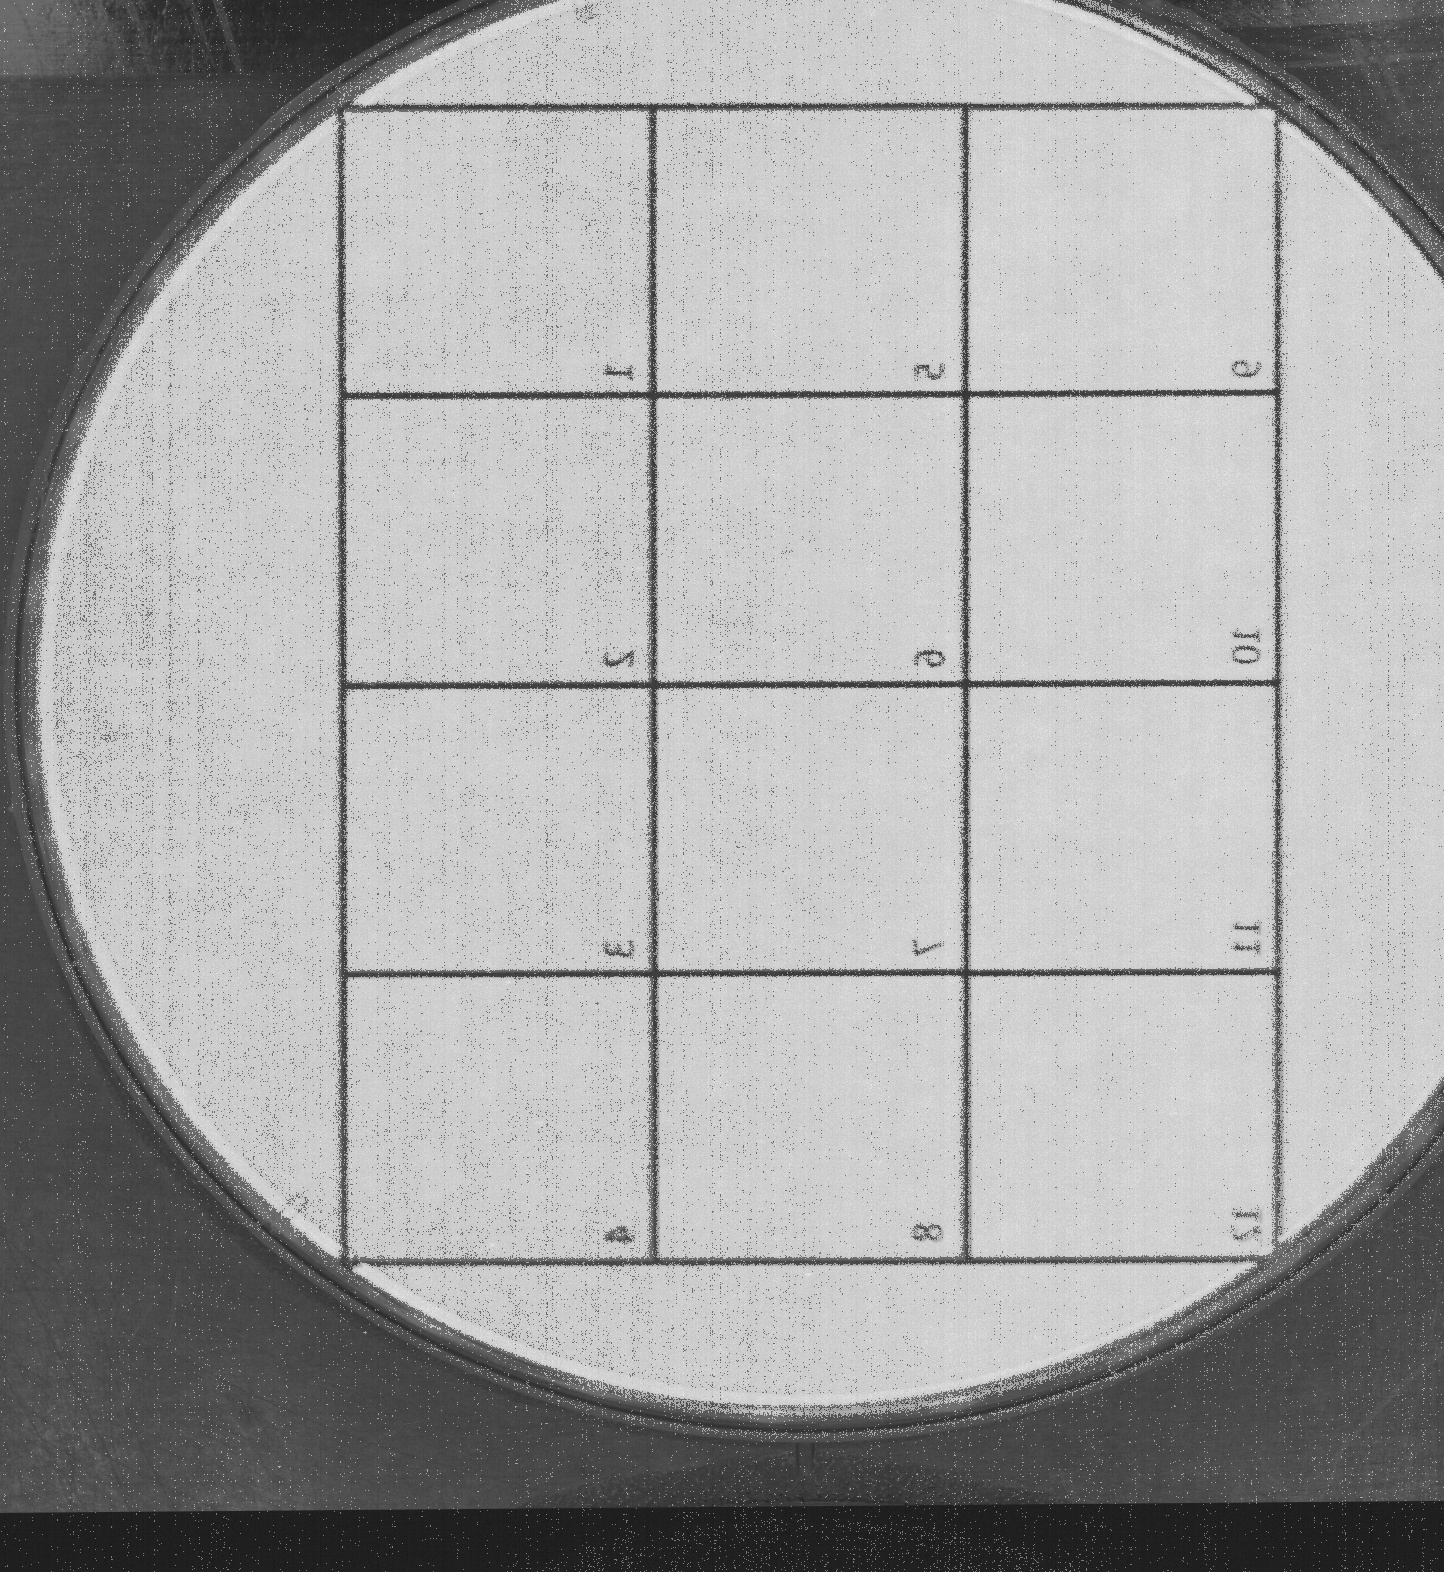

In [81]:
display < $aligned_grid

### Generate `csv` of hyperspectral channel for every image in dataset

This section is optional. It is useful to *make sure* the alignment works reasonably well for every image, but it can be slow.

In [83]:
if [ $test_align_each_img -eq 1 ]; then
hdr_files=$data/*.hdr
cd $alignment_path
conda activate test-environment
for hdr_file in $hdr_files
do
 csv_file=$(sed 's/Fluorescence.hdr/hyperchannel.csv/g' <<< $hdr_file)
 csv_file=$(sed 's/.hdr/_hyperchannel.csv/g' <<< $csv_file)
 csv_jpg=$(sed 's/csv/jpg/g' <<< $csv_file)
 python -W ignore hypercube_to_csv.py \
 $hdr_file \
 300 \
 219 \
 $csv_file \
 $csv_jpg >> ${data}log_hypercube2csv.txt
done
conda deactivate
fi

### Run batch alignment to apply homography matrix to all images

In [84]:
echo $hypercube_csv

/home/michael/GMOnotebook/existing_alignments/_GWAS_CRISPR_CRIA_wk3_stem_only_/hypercube_to_csv.csv


In [85]:
head "${data}/rgb_and_hyper_channel_lists.csv"

hyper_img,rgb_images
/media/michael/Expansio_15/Fuggle_vacuum_infiltration_and_sonication/wk4/chromagrid_I5.0_F1.9_L100LED30_134059_0_0_0_hyperchannel.csv,/media/michael/Expansio_15/Fuggle_vacuum_infiltration_and_sonication/wk4/chromagrid_I5.0_F1.9_L100LED30_134059_0_0_0_rgb.jpg
/media/michael/Expansio_15/Fuggle_vacuum_infiltration_and_sonication/wk4/FGLVS1_I5.0_F1.9_L100LED30_135819_0_0_0_hyperchannel.csv,/media/michael/Expansio_15/Fuggle_vacuum_infiltration_and_sonication/wk4/FGLVS1_I5.0_F1.9_L100LED30_135819_0_0_0_rgb.jpg
/media/michael/Expansio_15/Fuggle_vacuum_infiltration_and_sonication/wk4/FGLVS1_I5.0_F1.9_L100LED30_135934_1_0_1_hyperchannel.csv,/media/michael/Expansio_15/Fuggle_vacuum_infiltration_and_sonication/wk4/FGLVS1_I5.0_F1.9_L100LED30_135934_1_0_1_rgb.jpg
/media/michael/Expansio_15/Fuggle_vacuum_infiltration_and_sonication/wk4/FGLVS1_I5.0_F1.9_L100LED30_140104_2_0_2_hyperchannel.csv,/media/michael/Expansio_15/Fuggle_vacuum_infiltration_and_sonication/wk4/FGLVS1_I5.0_F1.

In [86]:
echo $homography

/home/michael/GMOnotebook/existing_alignments/_GWAS_CRISPR_CRIA_wk3_stem_only_/chromagrid_I5.0_F1.9_L100LED30_144832_0_0_0_rgb_homography.npy


In [87]:
conda activate alignment
cd $alignment_path
file_list_input="${data}/rgb_and_hyper_channel_lists.csv"
python main.py \
--hyper-img $hypercube_csv \
--img-csv $file_list_input \
--mode 2 \
--h_matrix_path $homography >> $data/log_alignment_mode2.txt
conda deactivate
conda deactivate

(alignment) (alignment) (alignment) (alignment) 

## Cross-analyze deep segmentation and regression results

Scripts in the <a href="https://github.com/naglemi/GMOlabeler" target="_blank">GMOlabeler repository</a> are used to cross-reference results from deep segmentation of RGB images and regression of hyperspectral imaging, apply thresholding parameters to classify tissues as transgenic or escapes, and produce plots.

<img src="Figures/GMOlabeler.png">

Figure: The various steps of data processing in GMOlabeler are illustrated for an example explant from an experiment on CIM optimization for cottonwood. Images of plates are cropped to a sub-image for each explant. RGB segmentation results and hyperspectral regression results are cross-referenced to calculate fluorecent proteins in specific tissues and infer whether these tissues are transgenic.

### Prepare sample datasheet input

Prepare input file we will use for making plots. This file contains paths to CLS results, RGB images, and hyperspectral images.

In [88]:
echo $data

/media/michael/Expansio_15//Fuggle_vacuum_infiltration_and_sonication/wk4/


In [89]:
echo $data

/media/michael/Expansio_15//Fuggle_vacuum_infiltration_and_sonication/wk4/


In [90]:
conda activate gmolabeler
cd "${cwd}/intermediates/"
Rscript pre_label.R \
-r "${data}/" \
-R "${output_directory_prefix}" \
-i 1 \
-d $datestamp
conda deactivate

(gmolabeler) (gmolabeler) [1] "”2022-05-05”"
[1] "Looking for CLS data in: /home/michael/data/gmodetector_out//Fuggle_vacuum_infiltration_and_sonication/wk4//"
[1] "2022-05-05"
[1] "Looking for CLS files in directory /home/michael/data/gmodetector_out//Fuggle_vacuum_infiltration_and_sonication/wk4//"
[1] "How many CLS files? 24"

[1] "Rows missing RGB data:"
   segment
1:    <NA>
2:    <NA>
                                                                                                                                                CLS_data
1: /home/michael/data/gmodetector_out//Fuggle_vacuum_infiltration_and_sonication/wk4///FGLVS1_I5.0_F1.9_L100LED30_141254_10_1_3_Fluorescence_weights.hdf
2:  /home/michael/data/gmodetector_out//Fuggle_vacuum_infiltration_and_sonication/wk4///FGLVS1_I5.0_F1.9_L100LED30_140704_6_0_6_Fluorescence_weights.hdf
    rgb
1: <NA>
2: <NA>

[1] "Rows missing segment data:"
   segment
1:    <NA>
2:    <NA>
                                                        

### Cross-reference RGB and hyperspectral data

On 1/11/20, we altered `gmolabeler` to accept user-defined borders of the grid box, rather than hardcoding these borders in for specific grids with 12 or 20 explants. Thus, if providing `grid_borders`, `grid` can be left as `None`, or vice versa. To determine the borders, open the *aligned* grid file in a GUI like GIMP or Microsoft Paint and use the crosshairs to find the pixel positions of each border. These are then provided through the `grid_borders` parameter in order "top bottom right left".

Some notes on grid copping parameters:
- Submit a space-delimited string with parameters for borders of grid as "left right bottom top"
- For FAA wk3, use parameters "139 1580 1250 312"
- For FAA wk7 and FAD wk7, use "156 1600 1280 335"
- For all images taken after re-centering of camera settings on 1/18/21, use "152 1592 1200 260" if images are of high resolution (2GB hyperspectral files) or "110 1356 1168 222" if of normal resolution (1.3GB hyperspectral files)

In [91]:
echo ${data}/samples_pre_labeling.csv

/media/michael/Expansio_15//Fuggle_vacuum_infiltration_and_sonication/wk4//samples_pre_labeling.csv


In [92]:
echo $aligned_grid

/home/michael/GMOnotebook/existing_alignments/_GWAS_CRISPR_CRIA_wk3_stem_only_/chromagrid_I5.0_F1.9_L100LED30_144832_0_0_0_rgb_aligned.jpg


In [93]:
echo $data_folder

/Fuggle_vacuum_infiltration_and_sonication/wk4/


In [95]:
# head $data/samples_pre_labeling.csv

In [96]:
echo $aligned_grid

/home/michael/GMOnotebook/existing_alignments/_GWAS_CRISPR_CRIA_wk3_stem_only_/chromagrid_I5.0_F1.9_L100LED30_144832_0_0_0_rgb_aligned.jpg


In [97]:
echo $reporters

DsRed


In [98]:
for reporter in ${reporters[@]}; do
    echo $reporter
done

DsRed


In [99]:
conda activate gmolabeler
cd $gmolabeler_path
for reporter in ${reporters[@]}; do
    python main.py \
    "${data}/samples_pre_labeling.csv" \
    $aligned_grid \
    $reporter_threshold \
    $reporter \
    $grid \
    "hdf" \
    $gmolabeler_path \
    "$aligned_grid_borders" > $data/log_gmolabeler_$reporter.txt
done
conda deactivate

(gmolabeler) (gmolabeler) (gmolabeler) 

### Calculate sums of statistics over combined segments

We are interested in all regenerated tissue (callus + shoot) as well as all tissue (including stem as well). We will calculate aggregate statistics over these groups.

In [100]:
conda activate gmolabeler
for reporter in ${reporters[@]}; do
    Rscript calculate_sum_stats_over_combined_segments.R \
    --output_dir "${gmolabeler_path}/output/" \
    --datapath "${data_folder}/${reporter}/"
done
conda deactivate

(gmolabeler) [1] "Writing output with sums statistics calculated over combined tissue segments to: /home/michael/GMOlabeler//output//Fuggle_vacuum_infiltration_and_sonication/wk4//DsRed/stats_with_sums_over_tissues.csv"
(gmolabeler) 

### Make plots of results

In [103]:
conda activate gmolabeler
cd $gmolabeler_path
for reporter in ${reporters[@]}; do
    Rscript grid_item_plots.R \
    -d "${data_folder}/" \
    -r "$randomization_datasheet" \
    -p $pixel_threshold \
    -v categorical \
    -m 1 \
    -M $missing_explants \
    -g $grid \
    --samples-pre-labeling ${data}/samples_pre_labeling.csv \
    --sort 1 \
    --height $height \
    --width $width \
    --Reporter $reporter
done
conda deactivate

(gmolabeler) (gmolabeler) Warning message:
In storage.mode(default) <- type : NAs introduced by coercion
[1] "Saving list of input arguments to : /home/michael/GMOlabeler/plots//Fuggle_vacuum_infiltration_and_sonication/wk4///DsRed/gridplot_args.rds"
[1] "Reading in output from GMOlabeler at path: /home/michael/GMOlabeler/output//Fuggle_vacuum_infiltration_and_sonication/wk4//DsRed/stats_with_sums_over_tissues.csv"

[1] "Rows in output from GMOlabeler: 1316"

[1] "Max n_pixels_passing_threshold in output from GMOlabeler: 1276"

[1] "Max total_signal in output from GMOlabeler: 175472.671576447"

[1] "Look at the top of output from GMOlabeler"
[1] "/media/michael/Expansio_15//Fuggle_vacuum_infiltration_and_sonication/wk4///FGLVS2_I5.0_F1.9_L100LED30_161358_2_0_2.png"
[2] "/media/michael/Expansio_15//Fuggle_vacuum_infiltration_and_sonication/wk4///FGLVS2_I5.0_F1.9_L100LED30_161358_2_0_2.png"
[3] "/media/michael/Expansio_15//Fuggle_vacuum_infiltration_and_sonication/wk4///FGLVS2_I5.0_F1.9_

In [104]:
echo $randomization_datasheet

/media/michael/Expansio_15//Fuggle_vacuum_infiltration_and_sonication/Test_4-8-22_Fuggle_vac_and_sonic_transformation.xlsx


## Email plots to user

### ZIP results

In [105]:
echo "${gmolabeler_path}/plots${data_folder}"

/home/michael/GMOlabeler//plots/Fuggle_vacuum_infiltration_and_sonication/wk4/


In [106]:
cd "${gmolabeler_path}/plots/${data_folder}"

In [107]:
rm -f ./plants_over_plates.csv

In [108]:
echo ${gmolabeler_path}/output/${data_folder}/

/home/michael/GMOlabeler//output//Fuggle_vacuum_infiltration_and_sonication/wk4//


In [109]:
#cp "${gmolabeler_path}/output/${data_folder}/plants_over_plates.csv" ./

In [110]:
for reporter in ${reporters[@]}; do
    cp "${gmolabeler_path}/output/${data_folder}/${reporter}/stats_with_sums_over_tissues.csv" ./
done

In [111]:
#cd $data

In [112]:
rm -f Rplots.pdf

In [113]:
cd ../

This messy substitution is explained here: https://superuser.com/questions/1068031/replace-backslash-with-forward-slash-in-a-variable-in-bash

In [114]:
data_folder_Compress="${data_folder////-}.zip"
data_folder_Compress=${data_folder_Compress#?};

In [115]:
echo $data_folder

/Fuggle_vacuum_infiltration_and_sonication/wk4/


In [116]:
echo $data_folder_Compress

Fuggle_vacuum_infiltration_and_sonication-wk4-.zip


In [117]:
pwd

/home/michael/GMOlabeler/plots/Fuggle_vacuum_infiltration_and_sonication


In [118]:
cd $timepoint

In [119]:
echo $timepoint

wk4


In [120]:
ls

DsRed  stats_with_sums_over_tissues.csv


In [121]:
cd $timepoint
zip -r $data_folder_Compress ./*

bash: cd: wk4: No such file or directory
  adding: DsRed/ (stored 0%)
  adding: DsRed/summary_stats_by_explant.csv (deflated 85%)
  adding: DsRed/summary_stats_by_plate.csv (deflated 79%)
  adding: DsRed/N of grid spots with X/ (stored 0%)
  adding: DsRed/N of grid spots with X/By genotype/ (stored 0%)
  adding: DsRed/N of grid spots with X/By genotype/3A2_Callus_transgenic.png (deflated 14%)
  adding: DsRed/N of grid spots with X/By genotype/3A1_Callus_total.png (deflated 14%)
  adding: DsRed/N of grid spots with X/By genotype/3B2_Shoot_transgenic.png (deflated 26%)
  adding: DsRed/N of grid spots with X/By genotype/3D1_All_regenerated_tissue_total.png (deflated 14%)
  adding: DsRed/N of grid spots with X/By genotype/3D2_All_regenerated_tissue_transgenic.png (deflated 14%)
  adding: DsRed/N of grid spots with X/By genotype/3D2_All_tissue_transgenic.png (deflated 13%)
  adding: DsRed/N of grid spots with X/By genotype/3B1_Shoot_total.png (deflated 16%)
  adding: DsRed/N of grid spots w

### Write email

In [122]:
duration=$(( SECONDS - start ))

https://unix.stackexchange.com/questions/53841/how-to-use-a-timer-in-bash

In [123]:
rm -f "${gmolabeler_path}/email_to_send.txt"
cp "${gmolabeler_path}/email_to_send_template.txt" "${gmolabeler_path}/email_to_send.txt"

In [124]:
echo "" >> "${gmolabeler_path}/email_to_send.txt"
echo "Number of samples run: " >> "${gmolabeler_path}/email_to_send.txt"

In [125]:
cat "${data}/test.csv" | wc -l >> "${gmolabeler_path}/email_to_send.txt"
echo "" >> "${gmolabeler_path}/email_to_send.txt"

In [126]:
if (( $SECONDS > 3600 )) ; then
    let "hours=SECONDS/3600"
    let "minutes=(SECONDS%3600)/60"
    let "seconds=(SECONDS%3600)%60"
    echo "Completed in $hours hour(s), $minutes minute(s) and $seconds second(s)" >> "${gmolabeler_path}/email_to_send.txt"
elif (( $SECONDS > 60 )) ; then
    let "minutes=(SECONDS%3600)/60"
    let "seconds=(SECONDS%3600)%60"
    echo "Completed in $minutes minute(s) and $seconds second(s)" >> "${gmolabeler_path}/email_to_send.txt"
else
    echo "Completed in $SECONDS seconds" >> "${gmolabeler_path}/email_to_send.txt"
fi

In [127]:
echo "" >> "${gmolabeler_path}/email_to_send.txt"

### Send email with results to user

In [128]:
pwd

/home/michael/GMOlabeler/plots/Fuggle_vacuum_infiltration_and_sonication/wk4


In [129]:
echo $data_folder_Compress

Fuggle_vacuum_infiltration_and_sonication-wk4-.zip


In [130]:
echo $data_folder

/Fuggle_vacuum_infiltration_and_sonication/wk4/


In [131]:
echo $email

chris.willig@oregonstate.edu


In [132]:
echo "${gmolabeler_path}/email_to_send.txt"

/home/michael/GMOlabeler//email_to_send.txt


In [133]:
pwd

/home/michael/GMOlabeler/plots/Fuggle_vacuum_infiltration_and_sonication/wk4


In [134]:
cat "${gmolabeler_path}/email_to_send.txt"


Your job is complete!

Number of samples run: 
24

Completed in 1 hour(s), 2 minute(s) and 10 second(s)



In [135]:
echo $data_folder_Compress

Fuggle_vacuum_infiltration_and_sonication-wk4-.zip


In [136]:
head $data_folder_Compress

PK
���I�֒�<B���h��$<$[�6�Gi�:A�_�>���O9.�??~|�uy��wƀ^4��wҬ-�9�����ç�?�}���1�l�p��'DH�����S��Z�Ť�:�A��[W���)l�{�Ab��&�f�EPܬ�A���ţnBr�0�.�S��$5k���}߯�h��(�m�M �)�j����b_����9�LWM��t��q�̴��:"%������?>���?�����O�ǇO��������}�������k���ǇO�{H����?�������/�����<|��{x��/~���c���=}���_�\���=|��o?�����R�մ�*������ßZ.�~�9��\K������j5��ʿ�5��?MIso޺�a1��d9�[��&1�R�Y<�Do�Ɏ��_�?~�痄�j
��:�B���w�խDjjc�9�01�O�˂���U����Ҟ�y��^F�Z�$�yT	M�pCȊ��U�m)��{�Ab��5$�e�eLܨ�TL��f�Vƨ���^��נ-�M�u�,C`!�����t�5"�T�Z�vU�����̺G)��I��:8#�����ѷ�fmr+ݳ-���D`ٗ1g�K��ʜ��+�	A�W��6 �F6�;f������X&�gXn�I�`���W����2"n��fBb��g��L:|��H�0��@�����ZA�s�ц�#N[�:���5�P��5�bXȦ���8>@ޔ�1f1,��܏������U�ng��E�3�y]��m&��
�LH�v��!Hc�պVM#Z@��-�RkQs��:zo=�{�`�D앵BĽ�[3�W��(��;��zG���;����,i��y���*48��������!�6
�����U5������N.��gJ:J������Lq�^��2P,&m�2�3�o��5t�e/1rP�:��՘��f5�
�L�K7C����|d�H�c �
n�eD*P��8��=u��<��fb�l�+�g��!d�|���e޵��D6 ?
�"	�g��

In [137]:
s-nail -a $data_folder_Compress -s $data_folder $email < "${gmolabeler_path}/email_to_send.txt"

=

: 1

In [138]:
du -sh $data_folder_Compress

du -sh $data_folder_Compress
4.3M	Fuggle_vacuum_infiltration_and_sonication-wk4-.zip


: 1

In [139]:
cat "${gmolabeler_path}/email_to_send.txt"

cat "${gmolabeler_path}/email_to_send.txt"

Your job is complete!

Number of samples run: 
24

Completed in 1 hour(s), 2 minute(s) and 10 second(s)



: 1

Time workflow ends:

In [140]:
echo $(date)

echo $(date)
Thu 05 May 2022 06:54:44 PM PDT


: 1